# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

## 1.1 Parameters

In [2]:
# Parameters
INDIR=""
N_DONORS=4
OUTDIR=""
sample_csv=""

In [3]:
# INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
# OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
# N_DONORS=4 


## 1.2 Import packages

In [1]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os

from vireoSNP import Vireo

import src.pseudo_batch as pb

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


fig_utils from mplh
here


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns


0.4.2


In [7]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

## 1.3 Load

In [5]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")
sample_labels = join(INDIR, "cell_labels.txt")

In [8]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()

AD_shape = AD.todense().shape

In [ ]:
# columns are 'ID', 'raw ID', and 'new index'. The first contains the
# suffix with the old id, the new index contains the mapping to the
# outputted subsampled cells, which is 1-based, and the raw ID is the initial cell IDs without the suffix.   
sample_labels = pd.read_csv(sample_labels)
sample_labels = sample_labels.sort_values('new index')
print('sample_labels', sample_labels.head())
print('AD_shape', AD_shape)
assert(AD_shape[1]) == sample_labels.shape[0] # These should match up.
    
if sample_csv != "":
    sample_df = pd.read_csv(sample_csv)
    sample_df = sample_df[['out_name', 'sample_name']]
    sample_df.columns = ["Name", "Sample"]
    sample_names = sample_df["Sample"].to_dict() #{0: "Control", 1:"Flt3"}
else:
    ## THIS IS GLOBAL VARIABLE HOTFIX
    sample_names = {0: "Control", 1:"Flt3"}

In [9]:
# cells = pd.read_csv(join(dirname(AD_F), "cellSNP.samples.tsv"), header=None)
# cells

# 2 Run vireo to demultiplex

## New implementation in v0.3.0

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

## 2.1 Run algorithm

### Multiple initialization is needed to avoid local optima
We pick the maximum model.

In [11]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=N_DONORS, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [12]:
## Choose the model giving highest ELBO
_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

In [ ]:
## Extract low-confident cells
doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)


## 2.2 Plot model performance

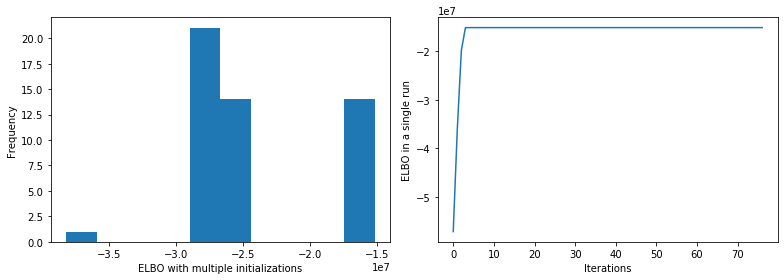

In [13]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

array([   34,    35,    49, ..., 18835, 18857, 18880])

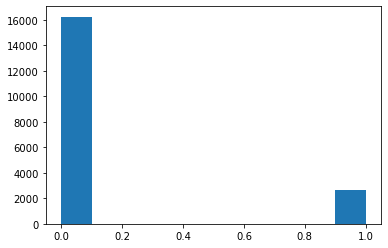

In [17]:

plt.hist(modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1))
# doublet_thresh = 0.9
# doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
# low_conf_cells = np.flatnonzero(doublet_prob > doublet_thresh)
# low_conf_cells
plt.title("Double probability")

# 3. Results

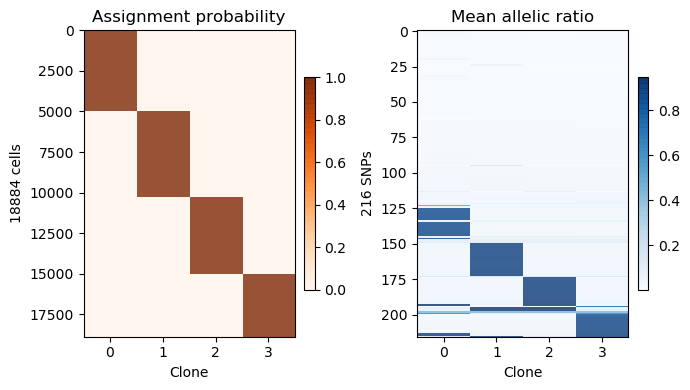

In [15]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.savefig(join(OUTDIR, "donors_multiplex.png"))
plt.show()


## Add in cell IDs to get sample information

cell inds ['data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_0.txt', 'data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_1.txt']
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_0.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/cell_indices_1.txt


Text(205.02197802197801, 0.5, 'Cell')

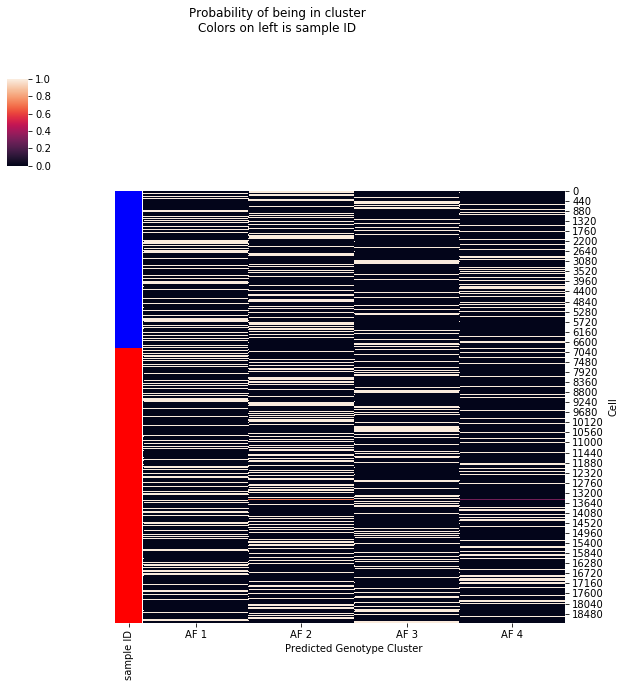

In [16]:
# A. 
# Input: cell indices files, where first line is name of file, and the rest is a df with column header of 'old index', 'new index'
# Output: A. cell_map: Dictionary where each key is the sample file (relative), and the value is the 'new index' column. 
        # B. in_cell_names: List of the keys, which are files
in_cell_f = glob(cell_inds_names)
print('cell inds', in_cell_f)
in_cell_names = []
cell_map = {}
for curr_cell_f in in_cell_f:
    print(curr_cell_f)
    with open(curr_cell_f, "r") as f:
        count = 0
        lines = []
        for line in f: 
            if count == 0:
                curr_f = line.strip()
            else:
                lines.append(line.strip().split(','))
            count += 1
    curr_df = pd.DataFrame(lines[1:], columns=lines[0])
    cell_map[curr_f] = curr_df["new index"].astype(int).values
    in_cell_names.append(curr_f)

# Get the maximum index across the two
max_v = 0
for i in in_cell_names:
    max_v = max(max_v, max(cell_map[i]))

# B. Input: in_cell_names: The list of keys
#    Output: cell_ind_map:  dict where keys are the sample map names and the values are unique ordered 0-indexed ints,
#                           with the order based on in_cell_names
cell_ind_map = {}
count = 0
for i in in_cell_names: 
    cell_ind_map[i] = count
    count += 1



# cell_inds: np.array where the length is the number of cells in the pseudo population, 
#            and the element is an int that maps to a sample based on the cell_ind_map. 
cell_inds = -1*np.ones(max_v)
for i in in_cell_names:
    cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]

# Assign colors to the samples.
sample_colors = pd.DataFrame([sample_names[x] for x in cell_inds], columns=["sample ID"])
colors = {0:"blue", 1:"red"}
cell_colors = [colors[x] for x in cell_inds]
cell_colors = pd.Series(cell_colors, name="sample ID")


## Plot result without clustering or doublet

In [ ]:
g = sns.clustermap(data=pd.DataFrame(modelCA.ID_prob, columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])]), row_cluster=False, col_cluster=False,
              row_colors=cell_colors)
#plt.ylabel("Cell")
#plt.xlabel("Predicted Genotype Cluster")


g.fig.suptitle("Probability of being in cluster\nColors on left is sample ID")
g.ax_heatmap.set_xlabel("Predicted Genotype Cluster")
g.ax_heatmap.set_ylabel("Cell")

#plt.savefig("pseudo_multiplex_with_cellIDs.png")

## Plot result with doublet probability

cmap None


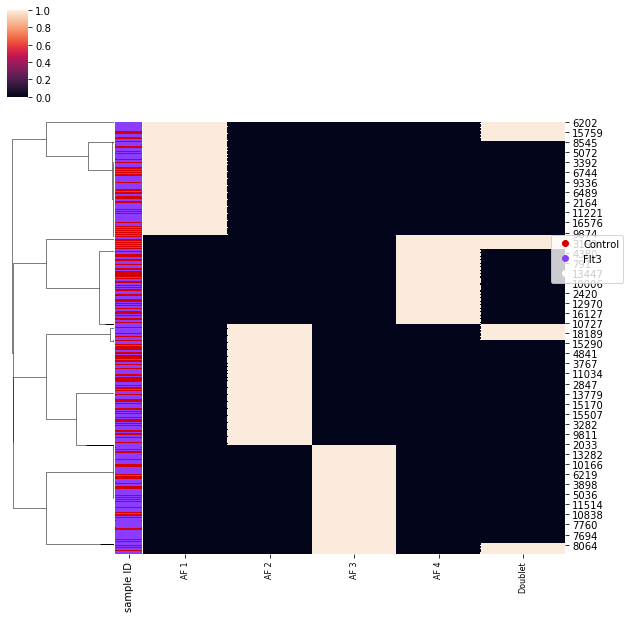

In [18]:
clust_df = pd.DataFrame(modelCA.ID_prob+np.random.uniform(low=0.0, high=0.0000005, size=modelCA.ID_prob.shape),
                       columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])])
clust_df = pd.concat((clust_df,pd.DataFrame(doublet_prob, columns=["Doublet"])), axis=1)

ch.plot_cluster(clust_df, 
                to_row_clust=True, to_col_clust=False,
                row_meta=pd.DataFrame(sample_colors), to_legend=True, white_name=None)

plt.savefig(join(OUTDIR, "clusters_with_sampleIDs.png"))


# 4. Extract donors

## Save confident cell IDs in a line-separated text file for each cluster. Additionally, save AD and DP files. If mixed samples, create a sample id file as well for all the barcodes combined. 

In [22]:
AD_dense = AD.todense()
DP_dense = DP.todense()

In [ ]:
# 0 index

In [28]:
prob_thresh=0.9
doublet_thresh = 0.9
low_conf_cells = np.flatnonzero(doublet_prob > doublet_thresh)

cell_clusters = dict()
#cell_clusters_names = dict()
for n in range(N_DONORS):
    # Drop low probability and/or high doublet probability
    cell_clusters[n] = np.flatnonzero((modelCA.ID_prob[:,n]>prob_thresh))
    cell_clusters[n] = cell_clusters[n][~(np.isin(cell_clusters[n], low_conf_cells))]
    
    curr_sample_colors = sample_colors.iloc[cell_clusters[n]].copy()
    curr_sample_colors = curr_sample_colors.reset_index()
    # Get cell labels 
    curr_sample_labels - sample_labels.iloc[cell_clusters[n]]
    
    #cell_clusters_names[n] = cells.loc[cell_clusters[n],0].values
    # Change the index to the sparse matrix index
    curr_ad = pd.DataFrame(AD.todense()[:, cell_clusters[n]]).reset_index().melt(id_vars='index', var_name="Cell", value_name="Count").rename({"index":"Position"}, axis=1)
    curr_dp = pd.DataFrame(DP.todense()[:, cell_clusters[n]]).reset_index().melt(id_vars='index', var_name="Cell", value_name="Count").rename({"index":"Position"}, axis=1)
    # Drop 0s
    curr_ad = curr_ad.loc[~(curr_ad["Count"]==0)]
    curr_dp = curr_dp.loc[~(curr_dp["Count"]==0)]
    
    #Update the map
    #curr_cell_label_map = {val: ind+1 for ind,val in enumerate(np.sort(curr_dp["Cell"].unique()))}
    curr_cell_map = {val: ind+1 for ind,val in enumerate(np.sort(curr_dp["Cell"].unique()))}
    curr_pos_map = {val: ind+1 for ind,val in enumerate(np.sort(curr_dp["Position"].unique()))}
    #curr_ad["Cell"].map(curr_cell_map)
    curr_ad["Cell"] = curr_ad["Cell"].map(curr_cell_map)
    curr_ad["Position"] = curr_ad["Position"].map(curr_pos_map)
    curr_dp["Cell"] = curr_dp["Cell"].map(curr_cell_map)
    curr_dp["Position"] = curr_dp["Position"].map(curr_pos_map)
    
    print(f"Donor {n}: {len(cell_clusters[n])} cells ")
    print(curr_dp.shape)
    print(curr_ad.shape)
    

    
    cell_clusters[n] += 1
    # Get their IDs 
    if OUTDIR != "" and exists(OUTDIR):
        curr_out = join(OUTDIR, f"donor{n}_cells.txt")
        curr_str = "\n".join(cell_clusters[n].astype(str))
        with open(curr_out,"w") as f:
            f.write(curr_str)

        curr_sample_colors.to_csv(join(OUTDIR, f"donor{n}.labels.txt"))
        curr_sample_labels.to_csv(join(OUTDIR, f"cell_labels.donor{n}.txt"))

        pb.wrap_write_mtx_df.wrap_write_mtx_df(OUTDIR, curr_ad, curr_dp, oth=None, to_rm=True,
                      prefix=f"donor{n}")
if OUTDIR!="":
    pd.DataFrame(AF_SNPs, columns = [f"Cluster {x}" for x in range(AF_SNPs.shape[1])]).to_csv(join(OUTDIR, "AF_SNPs.csv"), index=False)
cell_clusters

Cluster 0: 4118 cells 
(834055, 3)
(433196, 3)
Cluster 1: 4579 cells 
(927920, 3)
(453880, 3)
Cluster 2: 4305 cells 
(868072, 3)
(380878, 3)
Cluster 3: 3257 cells 
(664487, 3)
(314097, 3)


{0: array([    2,    11,    19, ..., 18877, 18879, 18882]),
 1: array([    3,     5,    10, ..., 18871, 18872, 18880]),
 2: array([    1,     4,     8, ..., 18873, 18883, 18884]),
 3: array([    6,     7,    12, ..., 18874, 18876, 18878])}

In [ ]:
        
#         curr_ad_f = join(OUTDIR, f"donor{n}.AD.txt")
#         curr_dp_f = join(OUTDIR, f"donor{n}.DP.txt")
        
#         header = "%%MatrixMarket matrix coordinate integer general\n%\n"
#         if os.path.exists(curr_ad_f):
#             os.remove(curr_ad_f)
#         if os.path.exists(curr_dp_f):
#             os.remove(curr_dp_f)

#         with open(curr_ad_f, 'a') as file:
#             file.write(header)
#             curr_ad = pd.concat((pd.DataFrame(
#                 {"Position": curr_ad["Position"].max(),
#                  "Cell": curr_ad["Cell"].max(),
#                  "Count": curr_ad.shape[0]}, index=["Meta"]),
#                                  curr_ad.sort_values(["Position", "Cell"])), sort=False)
#             curr_ad.to_csv(file, sep="\t", header=False, index=False)

#         with open(curr_dp_f, 'a') as file:
#             file.write(header)
#             curr_dp = pd.concat((pd.DataFrame(
#                 {"Position": curr_dp["Position"].max(),
#                  "Cell": curr_dp["Cell"].max(),
#                  "Count": curr_dp.shape[0]}, index=["Meta"]),
#                                  curr_dp.sort_values(["Position", "Cell"])))
#             curr_dp.to_csv(file, sep="\t", header=False, index=False)


## Total number of clustered cells

In [29]:
tot = 0
for i in cell_clusters.values():
    tot+=len(list(i))
tot

16259

# 5. QC of multiplexing by changing the number of donors and seeing if the loss satisfies the 'elbow rule'

### See if the N_DONOR satisfies the elbow loss rule
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [30]:
import pickle

In [31]:
### Run lineage tracing for each cluster individually
def run_elbo(ad, dp, out_f="", n_clone_list=None, save_clusters=True, labels=None):
    n_initials = 50


    if n_clone_list is None:
        n_clone_list = np.arange(2,5)
    _ELBO_mat = [] 
    for k in n_clone_list:
        print('lineages', k)
        _models_all = []
        _elbo_temp = []
        for i in range(50):
            _modelCA = Vireo(n_var=ad.todense().shape[0], n_cell=ad.todense().shape[1], n_donor=k, n_GT=2,
                             fix_beta_sum=False, ASE_mode=True)
            _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
            _modelCA.fit(ad, dp, min_iter=20, verbose=False)
            _elbo_temp.append(_modelCA.ELBO_[-1])
            _models_all.append(_modelCA)
            
        _ELBO_mat.append(_elbo_temp)
            
        # Run the plot_vireo_out
        ## Choose the model giving highest ELBO
        if save_clusters and not (out_f == ""):
            print('saving lineage tree for file:', out_f + f"clones{k}.lineages.png")
            _idx = np.argmax([x.ELBO_[-1] for x in _models_all])
            modelCA = _models_all[_idx]
            _losses = modelCA.ELBO_            
            pickle.dump(modelCA, open(out_f+f"clones{k}.modelCA.p", "wb"))
            doublet_prob = modelCA.predict_doublet(ad, dp, update_GT=False, update_ID=False)[0].sum(axis=1)
            plot_vireo_out(modelCA, out_f=out_f+f"clones{k}.lineages.png", to_sqrt=True, labels=labels, 
                          doublet_prob=doublet_prob)
            
    f = plt.figure()
    plt.boxplot(_ELBO_mat)
    plt.plot(np.arange(1,len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
    #plt.xticks(n_clone_list)
    plt.gca().set_xticklabels(n_clone_list)
    plt.ylabel("ELBO")
    plt.xlabel("n_clones")
    if out_f != "":
        plt.savefig(out_f)
    plt.show()
    return _ELBO_mat, n_clone_list


def plot_vireo_out(modelCA, out_f, to_sqrt=False, labels=None, doublet_prob=None):
    """
    Plots the output of demultiplexing, which is the clustermap of the probability, 
    along with the AF weights in each cluster
    """
    if labels is not None:
        clust_df = pd.DataFrame(modelCA.ID_prob+np.random.uniform(low=0.0, high=0.0000005, size=modelCA.ID_prob.shape),
                       columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])], index=labels.index)
        if doublet_prob is not None:
            clust_df = pd.concat((clust_df,pd.DataFrame(doublet_prob, columns=["Doublet"])), axis=1)
        ch.plot_cluster(clust_df, cmap='Oranges', alpha=0.8, 
                        to_row_clust=True, to_col_clust=False,
                        row_meta=labels, to_legend=True, white_name=None)
        plt.savefig(out_f+".labels.png")
    fig = plt.figure(figsize=(7, 4), dpi=100)
    plt.subplot(1, 2, 1)
    im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(modelCA.n_cell))
    plt.xticks(range(modelCA.n_donor))
    plt.subplot(1, 2, 2)
    AF_SNPs = np.sum(modelCA.GT_prob * 
                     np.expand_dims(modelCA.beta_mu, 1), axis=2)
    if to_sqrt:
        AF_SNPs = np.sqrt(AF_SNPs)

    im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                     display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" %(modelCA.n_var))
    plt.xticks(range(modelCA.n_donor))
    plt.tight_layout()
    plt.savefig(out_f)
    plt.show()
    return

lineages 2
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/elbow_plot.pngclones2.lineages.png


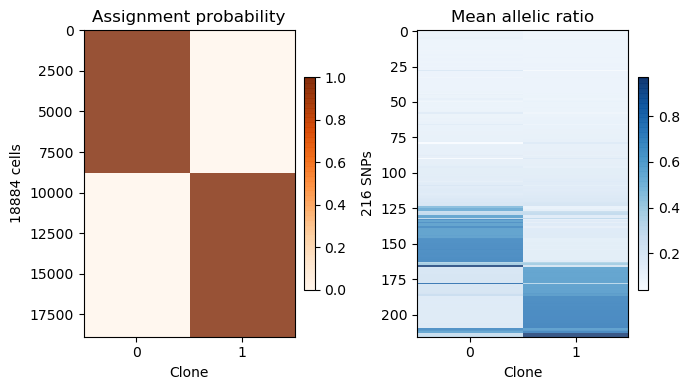

lineages 3
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/elbow_plot.pngclones3.lineages.png


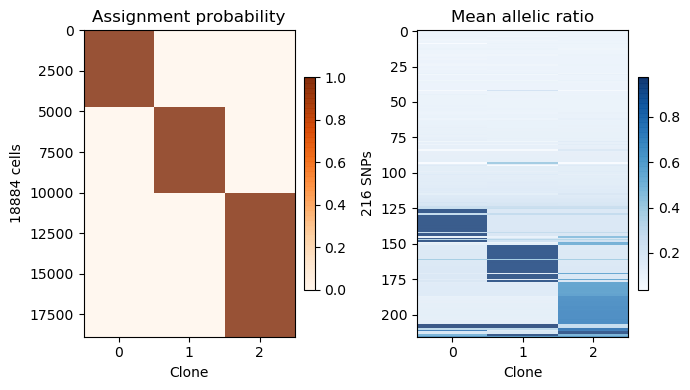

lineages 4
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/elbow_plot.pngclones4.lineages.png


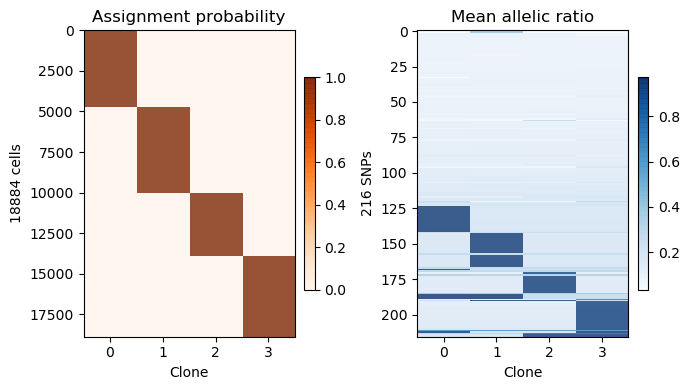

lineages 5
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/elbow_plot.pngclones5.lineages.png


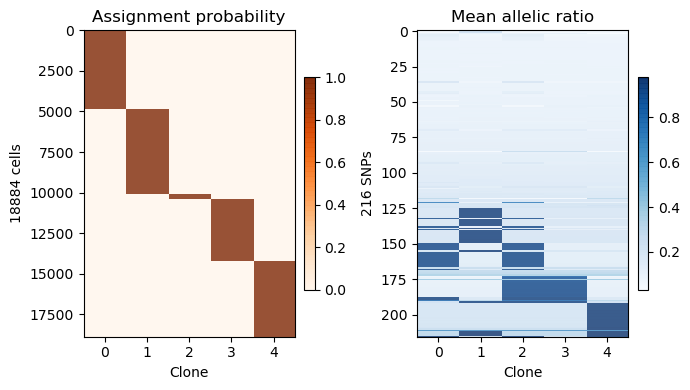

lineages 6
saving lineage tree for file: data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/elbow_plot.pngclones6.lineages.png


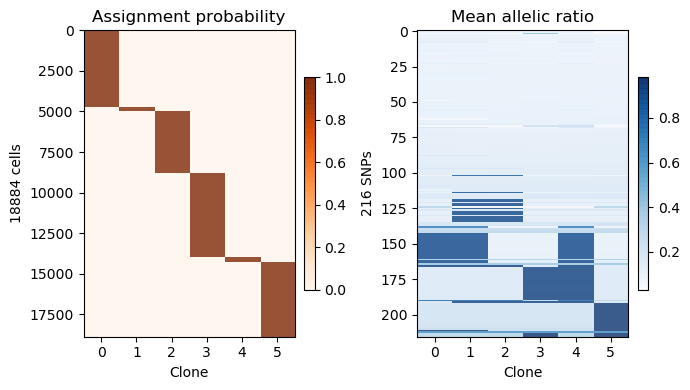

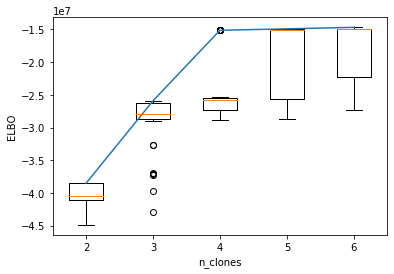

([[-40433281.40761244,
   -38506098.57539889,
   -41092382.05002504,
   -38505088.664518625,
   -41092138.63251711,
   -38804370.84546501,
   -38506203.19699219,
   -38505883.60594938,
   -38505264.284352824,
   -38803782.39287035,
   -38805397.73558385,
   -41092027.148015514,
   -38506099.56447671,
   -38506279.63661319,
   -38804245.84409004,
   -41092892.464051045,
   -38505818.83082299,
   -41091985.8608763,
   -42534238.85516803,
   -38505057.40339903,
   -41092668.631773904,
   -38804104.64722293,
   -40433852.04437803,
   -40434530.47046869,
   -41091893.133980155,
   -41099510.71398474,
   -38804169.48257175,
   -42533424.195074126,
   -40434037.927041814,
   -42534068.42004721,
   -41092814.413172916,
   -38506343.42998525,
   -41092389.29376424,
   -38505990.01041663,
   -41091706.287152804,
   -38506635.27185196,
   -40434015.1366277,
   -38506332.25229399,
   -42533798.17394425,
   -38804179.60061405,
   -38506160.062838115,
   -44887035.72575618,
   -41092079.393663555,
 

In [34]:
run_elbo(AD, DP, out_f=join(OUTDIR, "elbow_plot.png"), n_clone_list=np.arange(N_DONORS-2, N_DONORS+3))

# 6. Run each demultiplexed donor lineage tracing separately
### Run with the number of clones being 2-7

In [32]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = N_DONORS #multiprocessing.cpu_count()
inputs = tqdm(np.arange(N_DONORS))

def run_lineage(n, OUTDIR, n_clone_list=[2,10,20,100]):
    curr_ad_f = join(OUTDIR, f"donor{n}.AD.txt")
    curr_dp_f = join(OUTDIR, f"donor{n}.DP.txt")
    print(curr_ad_f)
    print(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    curr_labels = pd.read_csv(join(OUTDIR, f"donor{n}.labels.txt"), index_col=0)
    curr_names = pd.read_csv(join(OUTDIR, f"cell_labels.donor{n}.txt"), index_col=0)    
    run_elbo(curr_ad, curr_dp, join(OUTDIR, f"donor{n}_lineage_elbow.png"), n_clone_list=n_clone_list,
             save_clusters=True, labels=curr_labels[["sample ID"]])
    return

def test(n, OUTDIR):
    print('n')
    return n+10
processed_list = Parallel(n_jobs=num_cores)(delayed(run_lineage)(i,OUTDIR) for i in inputs)

100%|██████████| 4/4 [00:00<00:00, 41.65it/s]


In [33]:
# for n in range(N_DONORS):
#     print('Cluster', n)
#     curr_ad_f = join(OUTDIR, f"donor{n}.AD.txt")
#     curr_dp_f = join(OUTDIR, f"donor{n}.DP.txt")
#     curr_ad = mmread(curr_ad_f).tocsc()
#     curr_dp = mmread(curr_dp_f).tocsc()
#     curr_labels = pd.read_csv(join(OUTDIR, f"donor{n}.labels.txt"), index_col=0)
#     run_elbo(curr_ad, curr_dp, join(OUTDIR, f"donor{n}_lineage_elbow.png"), n_clone_list=[2,3,4,5],
#              save_clusters=True, labels=curr_labels[["sample ID"]])

